In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Banded Mongoose vocalizations
Source:
- https://www.zora.uzh.ch/id/eprint/78275/1/David_Jansen_PhD_thesis_03MAY13.pdf
- https://mynotebook.labarchives.com/doi/OTAxMC4zfDY5MzEvNjkzMS9Ob3RlYm9vay80MTA2NzYyMjY3fDIyODcyLjM=/10.6070/H4W37T8Q

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
from datetime import datetime

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/mongoose')

In [7]:
WAVLIST = list((DSLOC / '1. orgional recordings').expanduser().glob('*.wav'))
len(WAVLIST)

495

In [8]:
WAVLIST[0].stem.split('_')

['close call',
 'search',
 '15',
 'M50',
 '9.13',
 '20090923am',
 '15',
 'M50',
 'focal',
 'audio']

In [9]:
np.unique([len(wf.stem.split('_')) for wf in WAVLIST])

array([ 5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
# parse wav file name
syllable_df = pd.DataFrame(
    columns=[
        "call_type",
        "group",
        "indv",
        "date",
        "dist",
        "wav_loc",
        "rate",
        "vocdata",
        "voc_len",
    ]
)
for wf in WAVLIST:
    wav_items = wf.stem.split("_")

    if len(wav_items) > 5:
        close_call = wav_items[0]
        search_move_forage = wav_items[1]
        group = wav_items[2]
        indv_ID = wav_items[3]
        dist = wav_items[4]
        date = wav_items[5].split(" ")[0]
    else:
        close_call = wav_items[0]
        search_move_forage = wav_items[1]
        group = wav_items[2]
        indv_ID = wav_items[3]
        date = wav_items[4].split(" ")[0]
        dist = None
    try:
        datetime_object = datetime.strptime(date, "%Y%m%d%p")
    except:
        try:
            datetime_object = datetime.strptime(date, "%Y%m%d")
        except:
            try:
                close_call = wav_items[0]
                search_move_forage = wav_items[1]
                group = wav_items[2]
                indv_ID = wav_items[3]
                date = wav_items[4].split(" ")[0]
                datetime_object = datetime.strptime(date, "%Y%m%d%p")
            except:
                try:
                    close_call = wav_items[0]
                    search_move_forage = wav_items[1]
                    group = wav_items[2]
                    indv_ID = wav_items[3]
                    dist = wav_items[5]
                    date = wav_items[6].split(" ")[0]
                    datetime_object = datetime.strptime(date, "%Y%m%d%p")
                except:
                    continue

    rate, data = load_wav(wf)

    if rate is None: 
        print('test')
        continue
    
    data = butter_bandpass_filter(data, lowcut = 500, highcut=15000, fs=rate, order=4)

    syllable_df.loc[len(syllable_df)] = [
        search_move_forage,
        group,
        indv_ID,
        date,
        dist,
        wf,
        rate,
        data,
        len(data) / rate,
    ]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Unsupported bit depth: the wav file has 24-bit data.
test
Unsupported bit depth: the wav file has 24-bit data.
test


In [11]:
len(syllable_df)

489

In [12]:
syllable_df[:3]

,call_type,group,indv,date,dist,wav_loc,rate,vocdata,voc_len
0,search,15,M50,20090923am,9.13,/mnt/cube/Datasets/mongoose/1. orgional record...,44100,"[6.060841181458646, 14.491478295106566, 2.9347...",0.151088
1,move,1H,F80,20100316am,3.08,/mnt/cube/Datasets/mongoose/1. orgional record...,44100,"[-27.161547516907266, -101.86537075030316, -13...",0.437392
2,move,11,M54,20110524am,0.44,/mnt/cube/Datasets/mongoose/1. orgional record...,44100,"[1355.1591930542907, 4628.926282431502, 5394.3...",0.285941


In [14]:
len(np.unique(syllable_df.indv))

42

In [21]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/mnt/c

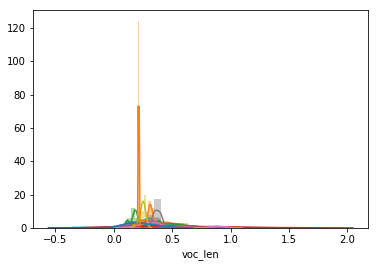

In [22]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(syllable_df[syllable_df.indv==indv]["voc_len"], label=indv)
#plt.legend()

### Create spectrogram

In [23]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix

In [82]:
win_length_ms = 5
hop_length_ms = 1
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-50,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=20,
    mel_upper_edge_hertz=4000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

220.5
44.1


In [98]:
audio = int16_to_float32(syllable_df.vocdata.values[18])
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

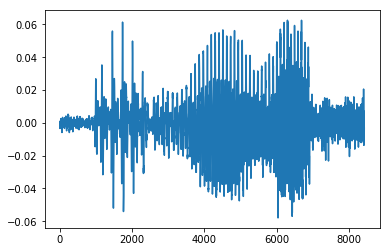

In [99]:
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate)

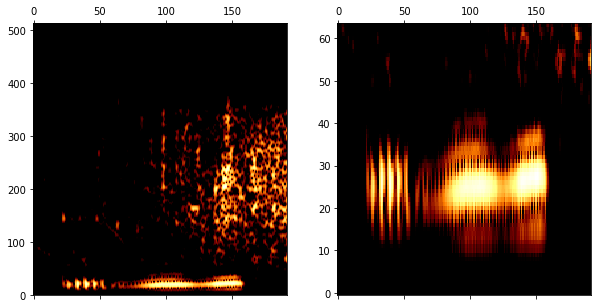

In [100]:
fig, axs = plt.subplots(ncols = 2, figsize=(10,5))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')